In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Function to prepare the dataset for modeling with custom features
def prepare_dataset(data, target_col, features, n_lags=4, n_ahead=10):
    X, y = [], []
    max_lag = max(features.get('lags', [0]) + [0])
    exog_lags_max = max([max(lags) for lags in features.get('exog_lags', {}).values()] + [0])
    start_idx = max(max_lag, exog_lags_max)
    for i in range(start_idx, len(data) - n_ahead):
        # Build feature vector
        X_i = []
        # Include lags of target variable
        if 'lags' in features:
            for lag in features['lags']:
                X_i.append(data[target_col].values[i - lag])
        # Include exogenous variables
        if 'exog' in features:
            for exog_var in features['exog']:
                X_i.append(data[exog_var].values[i])
        # Include lags of exogenous variables
        if 'exog_lags' in features:
            for exog_var, lags in features['exog_lags'].items():
                for lag in lags:
                    X_i.append(data[exog_var].values[i - lag])
        X.append(X_i)
        y.append(data[target_col].values[i:i + n_ahead])  # next n_ahead steps
    return np.array(X, dtype=float), np.array(y, dtype=float)

# List to store datasets and their corresponding features
datasets = []

# ==========================
# Univariate Time Series
# ==========================

# 1. AirPassengers Dataset
print("Loading AirPassengers dataset...")
air_passengers = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
                             parse_dates=['Month'], index_col='Month')
air_passengers.rename(columns={'Passengers': 'y'}, inplace=True)
air_passengers['MonthOfYear'] = air_passengers.index.month  # Add month as a feature
air_passengers['MonthSin'] = np.sin(2 * np.pi * air_passengers.index.month / 12)
air_passengers['MonthCos'] = np.cos(2 * np.pi * air_passengers.index.month / 12)

# Define features for AirPassengers
features_air_passengers = {
    'lags': [1, 12],  # Include lag 1 and lag 12 to capture seasonality
    'exog': ['MonthSin', 'MonthCos']
}

datasets.append(('AirPassengers', air_passengers, features_air_passengers))

# 2. Sunspots Dataset
print("Loading Sunspots dataset...")
sunspots = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv',
                       parse_dates=['Month'], index_col='Month')
sunspots.rename(columns={'Sunspots': 'y'}, inplace=True)
sunspots['MonthOfYear'] = sunspots.index.month
sunspots['YearSin'] = np.sin(2 * np.pi * sunspots.index.month / 12)
sunspots['YearCos'] = np.cos(2 * np.pi * sunspots.index.month / 12)

# Define features for Sunspots
features_sunspots = {
    'lags': [1, 2, 11, 12, 13],  # Include lags to capture cycles
    'exog': ['YearSin', 'YearCos']
}

datasets.append(('Sunspots', sunspots, features_sunspots))

# ==========================
# Multivariate Time Series
# ==========================

# 3. Weather Dataset (Daily Max Temperatures)
print("Loading Daily Max Temperatures dataset...")
temperatures = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv',
                           parse_dates=['Date'], index_col='Date')
temperatures.rename(columns={'Temp': 'y'}, inplace=True)
temperatures['DayOfYear'] = temperatures.index.dayofyear
temperatures['YearSin'] = np.sin(2 * np.pi * temperatures.index.dayofyear / 365)
temperatures['YearCos'] = np.cos(2 * np.pi * temperatures.index.dayofyear / 365)

# Define features for Temperatures
features_temperatures = {
    'lags': [1, 365],  # Include lag 1 and 365 to capture daily changes and yearly seasonality
    'exog': ['YearSin', 'YearCos']
}

datasets.append(('DailyMaxTemperatures', temperatures, features_temperatures))

# 4. Electricity Consumption Dataset (Household Power Consumption)
print("Loading Electricity Consumption dataset...")
power = pd.read_csv(
    'https://raw.githubusercontent.com/sajalsuhane/household_power_consumption/master/household_power_consumption.csv',
    parse_dates=['Date'],
    index_col='Date',
    na_values='?'  # Specify that '?' represents missing values
)
power = power.iloc[:75000, :]
# Convert columns to numeric
cols = power.columns
power[cols] = power[cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values
power.fillna(method='ffill', inplace=True)

power.rename(columns={'Global_active_power': 'y'}, inplace=True)
# Create additional features
power['DayOfWeek'] = power.index.dayofweek
power['WeekOfYear'] = power.index.isocalendar().week.astype(int)
power['DaySin'] = np.sin(2 * np.pi * power.index.dayofweek / 7)
power['DayCos'] = np.cos(2 * np.pi * power.index.dayofweek / 7)

# Define features for Electricity Consumption
features_power = {
    'lags': [1, 7, 14],  # Lag 1, 7, 14 to capture daily and weekly patterns
    'exog': ['Global_reactive_power', 'Voltage', 'DaySin', 'DayCos'],
    'exog_lags': {
        'Global_reactive_power': [1, 7],
        'Voltage': [1, 7]
    }
}

datasets.append(('ElectricityConsumption', power, features_power))


datasets

Loading AirPassengers dataset...
Loading Sunspots dataset...
Loading Daily Max Temperatures dataset...
Loading Electricity Consumption dataset...


[('AirPassengers',
                y  MonthOfYear      MonthSin      MonthCos
  Month                                                   
  1949-01-01  112            1  5.000000e-01  8.660254e-01
  1949-02-01  118            2  8.660254e-01  5.000000e-01
  1949-03-01  132            3  1.000000e+00  6.123234e-17
  1949-04-01  129            4  8.660254e-01 -5.000000e-01
  1949-05-01  121            5  5.000000e-01 -8.660254e-01
  ...         ...          ...           ...           ...
  1960-08-01  606            8 -8.660254e-01 -5.000000e-01
  1960-09-01  508            9 -1.000000e+00 -1.836970e-16
  1960-10-01  461           10 -8.660254e-01  5.000000e-01
  1960-11-01  390           11 -5.000000e-01  8.660254e-01
  1960-12-01  432           12 -2.449294e-16  1.000000e+00
  
  [144 rows x 4 columns],
  {'lags': [1, 12], 'exog': ['MonthSin', 'MonthCos']}),
 ('Sunspots',
                 y  MonthOfYear       YearSin       YearCos
  Month                                                


Processing AirPassengers dataset...

Results for AirPassengers dataset:
Native Multioutput RandomForestRegressor:
Average MSE: 5692.5817
Average MAPE: 0.1768

MultiOutputRegressor with RandomForestRegressor:
Average MSE: 4796.1657
Average MAPE: 0.1594


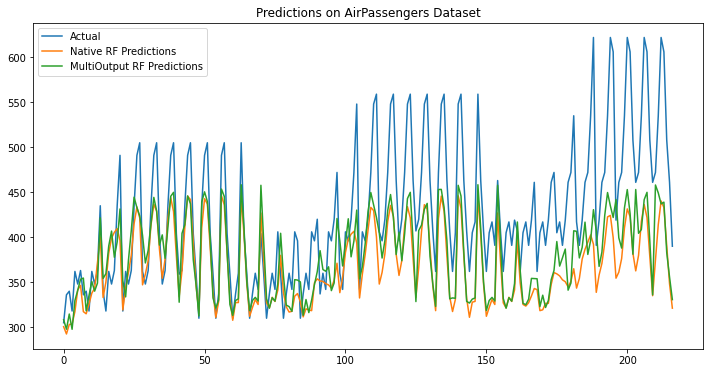


Processing Sunspots dataset...

Results for Sunspots dataset:
Native Multioutput RandomForestRegressor:
Average MSE: 502.2470
Average MAPE: 1078163282629105.5000

MultiOutputRegressor with RandomForestRegressor:
Average MSE: 501.7819
Average MAPE: 1027629984320453.3750


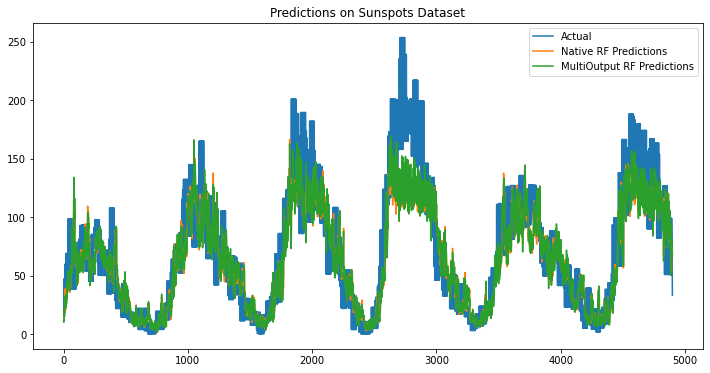


Processing DailyMaxTemperatures dataset...

Results for DailyMaxTemperatures dataset:
Native Multioutput RandomForestRegressor:
Average MSE: 8.4704
Average MAPE: 0.2930

MultiOutputRegressor with RandomForestRegressor:
Average MSE: 8.6485
Average MAPE: 0.2928


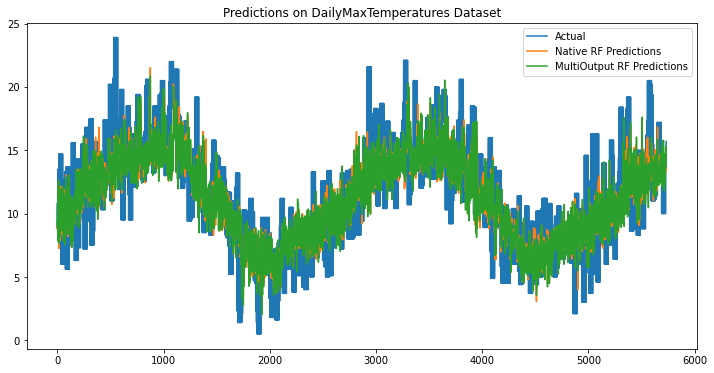


Processing ElectricityConsumption dataset...

Results for ElectricityConsumption dataset:
Native Multioutput RandomForestRegressor:
Average MSE: 0.4020
Average MAPE: 0.3636

MultiOutputRegressor with RandomForestRegressor:
Average MSE: 0.4002
Average MAPE: 0.3600


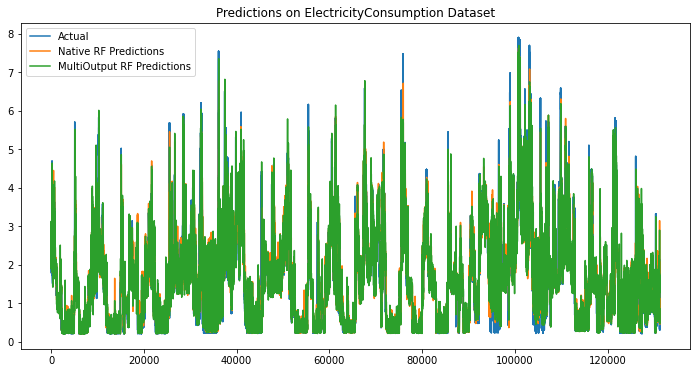

In [2]:

# ==========================
# Modeling and Evaluation
# ==========================

for name, data, features in datasets:
    print(f"\nProcessing {name} dataset...")
    # Prepare the dataset
    n_ahead = 7
    X, y = prepare_dataset(data, 'y', features, n_ahead=n_ahead)
    
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits=3)
    
    # Initialize lists to store errors
    mse_native_list, mape_native_list = [], []
    mse_multioutput_list, mape_multioutput_list = [], []
    
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # 2.a Native multioutput capability
        rf_native = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_native.fit(X_train, y_train)
        y_pred_native = rf_native.predict(X_test)
        
        # 2.b Using MultiOutputRegressor
        rf_base = RandomForestRegressor(n_estimators=100, random_state=0)
        rf_multioutput = MultiOutputRegressor(rf_base)
        rf_multioutput.fit(X_train, y_train)
        y_pred_multioutput = rf_multioutput.predict(X_test)
        
        # 3. Compute MSE and MAPE
        mse_native = mean_squared_error(y_test, y_pred_native)
        mape_native = mean_absolute_percentage_error(y_test, y_pred_native)
        mse_multioutput = mean_squared_error(y_test, y_pred_multioutput)
        mape_multioutput = mean_absolute_percentage_error(y_test, y_pred_multioutput)
        
        mse_native_list.append(mse_native)
        mape_native_list.append(mape_native)
        mse_multioutput_list.append(mse_multioutput)
        mape_multioutput_list.append(mape_multioutput)
    
    # Compute average errors
    avg_mse_native = np.mean(mse_native_list)
    avg_mape_native = np.mean(mape_native_list)
    avg_mse_multioutput = np.mean(mse_multioutput_list)
    avg_mape_multioutput = np.mean(mape_multioutput_list)
    
    print(f"\nResults for {name} dataset:")
    print("Native Multioutput RandomForestRegressor:")
    print(f"Average MSE: {avg_mse_native:.4f}")
    print(f"Average MAPE: {avg_mape_native:.4f}")
    
    print("\nMultiOutputRegressor with RandomForestRegressor:")
    print(f"Average MSE: {avg_mse_multioutput:.4f}")
    print(f"Average MAPE: {avg_mape_multioutput:.4f}")
    
    # Optional: Plot the predictions of the last fold
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(y_test.flatten())), y_test.flatten(), label='Actual')
    plt.plot(range(len(y_pred_native.flatten())), y_pred_native.flatten(), label='Native RF Predictions')
    plt.plot(range(len(y_pred_multioutput.flatten())), y_pred_multioutput.flatten(), label='MultiOutput RF Predictions')
    plt.title(f'Predictions on {name} Dataset')
    plt.legend()
    plt.show()
